# 数据集构建

DISC-Law-SFT数据集下载：git clone https://www.modelscope.cn/datasets/Robin021/DISC-Law-SFT.git  

data/DISC-Law-SFT/DISC-Law-SFT-Pair.jsonl文件中，每个样本包含3项："id", "input", "output"，例如，第1个样本内容如下：

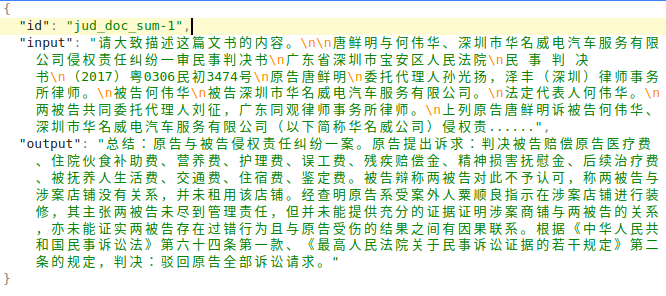

data/DISC-Law-SFT/DISC-Law-SFT-Triplet-released.jsonl文件中，每个样本包含4项："id", "reference", "input", "output"，例如，第1个样本内容如下：  

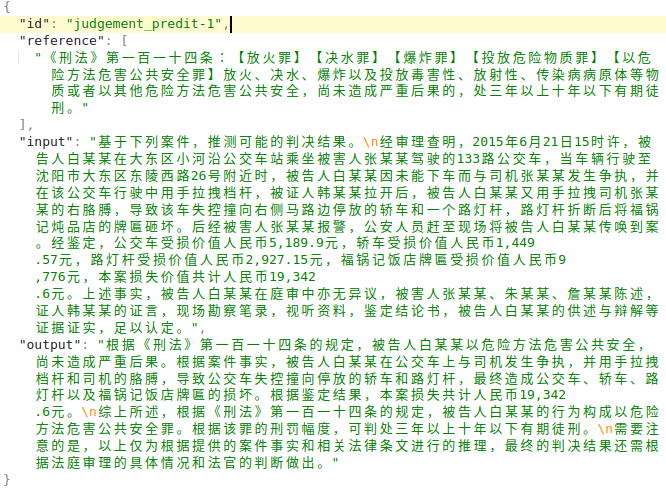

Qwen的SFT数据格式要求（这是ShareGPT格式）:
```
[
  {
    "id": "identity_0",
    "conversations": [
      {
        "from": "user",
        "value": "你好"
      },
      {
        "from": "assistant",
        "value": "我是一个语言模型，我叫通义千问。"
      }
    ]
  }
]
```

所以，我们要抽取data/DISC-Law-SFT/DISC-Law-SFT-Triplet-released.jsonl中样本的"input"和"output"，分别做为"user"和"assistant"的"value"值。

In [ ]:
import json

# 读取原始数据集文件
json_data = []
with open('data/DISC-Law-SFT/DISC-Law-SFT-Triplet-released.jsonl', 'r', encoding='utf-8') as file:
	for line in file:
		data = json.loads(line)
		json_data.append(data)

# 待填入的模板
template = []

# 遍历json数据集
for idx, data in enumerate(json_data[:]):
   conversation = [
       {
           "from": "user",
           "value": data["input"]
       },
       {
           "from": "assistant",
           "value": data["output"]
       }
   ]

   template.append({
       "id": f"identity_{idx}",
       "conversations": conversation
   })
print(f"总共处理了 {len(template)} 条数据。")

# 输出填充数据后的模板
print(json.dumps(template[0], ensure_ascii=False, indent=2))

# 将template写入到本地文件
output_file_path = "data/train_data_law.json"
with open(output_file_path, 'w', encoding='utf-8') as f:
   json.dump(template, f, ensure_ascii=False, indent=2)

print(f"处理好的数据已写入到本地文件: {output_file_path}")

总共处理了 16000 条数据。
{
  "id": "identity_0",
  "conversations": [
    {
      "from": "user",
      "value": "基于下列案件，推测可能的判决结果。\n经审理查明，2015年6月21日15时许，被告人白某某在大东区小河沿公交车站乘坐被害人张某某驾驶的133路公交车，当车辆行驶至沈阳市大东区东陵西路26号附近时，被告人白某某因未能下车而与司机张某某发生争执，并在该公交车行驶中用手拉拽档杆，被证人韩某某拉开后，被告人白某某又用手拉拽司机张某某的右胳膊，导致该车失控撞向右侧马路边停放的轿车和一个路灯杆，路灯杆折断后将福锅记炖品店的牌匾砸坏。后经被害人张某某报警，公安人员赶至现场将被告人白某某传唤到案。经鉴定，公交车受损价值人民币5,189.9元，轿车受损价值人民币1,449.57元，路灯杆受损价值人民币2,927.15元，福锅记饭店牌匾受损价值人民币9,776元，本案损失价值共计人民币19,342.6元。上述事实，被告人白某某在庭审中亦无异议，被害人张某某、朱某某、詹某某陈述，证人韩某某的证言，现场勘察笔录，视听资料，鉴定结论书，被告人白某某的供述与辩解等证据证实，足以认定。"
    },
    {
      "from": "assistant",
      "value": "根据《刑法》第一百一十四条的规定，被告人白某某以危险方法危害公共安全，尚未造成严重后果。根据案件事实，被告人白某某在公交车上与司机发生争执，并用手拉拽档杆和司机的胳膊，导致公交车失控撞向停放的轿车和路灯杆，最终造成公交车、轿车、路灯杆以及福锅记饭店牌匾的损坏。根据鉴定结果，本案损失共计人民币19,342.6元。\n综上所述，根据《刑法》第一百一十四条的规定，被告人白某某的行为构成以危险方法危害公共安全罪。根据该罪的刑罚幅度，可判处三年以上十年以下有期徒刑。\n需要注意的是，以上仅为根据提供的案件事实和相关法律条文进行的推理，最终的判决结果还需根据法庭审理的具体情况和法官的判断做出。"
    }
  ]
}
处理好的数据已写入到本地文件: data/train_data_law.json


In [2]:
# 这种处理方式有2个问题：
# 1、data/DISC-Law-SFT/DISC-Law-SFT-Pair.jsonl文件中有些样本只有input，没有output，需要过滤掉。
# 2、两个文件的id是独立的，需要把id连贯起来。

import json

def parse_jsonl_file(file_path):
    """
    解析单个jsonl文件并返回模板数据。
    file_path: jsonl文件路径
    return: 填充后的模板数据列表
    """
    json_data = []
    # 读取原始数据集文件
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            data = json.loads(line)
            json_data.append(data)

    template = []

    # 遍历 JSON 数据集
    for idx, data in enumerate(json_data):
        conversation = [
            {
                "from": "user",
                "value": data["input"]
            },
            {
                "from": "assistant",
                "value": data["output"]
            }
        ]

        template.append({
            "id": f"identity_{idx}",
            "conversations": conversation
        })

    return template

def process_multiple_files(file_paths, output_file_path):
    """
    处理多个jsonl文件并将结果合并后写入到输出文件。
    :file_paths: jsonl文件路径列表
    :output_file_path: 输出文件路径
    """
    combined_template = []

    # 遍历每个文件并解析
    for file_path in file_paths:
        print(f"正在处理文件: {file_path}")
        template = parse_jsonl_file(file_path)
        combined_template.extend(template)

    print(f"总共处理了 {len(combined_template)} 条数据。")

    # 输出填充数据后的模板
    print(json.dumps(combined_template[0], ensure_ascii=False, indent=2))

    # 将合并后的模板写入到本地文件
    with open(output_file_path, 'w', encoding='utf-8') as f:
        json.dump(combined_template, f, ensure_ascii=False, indent=2)

    print(f"处理好的数据已写入到本地文件: {output_file_path}")

# 要解析的两个JSONL文件路径
file_paths = [
    'data/DISC-Law-SFT/DISC-Law-SFT-Triplet-released.jsonl',
    'data/DISC-Law-SFT/DISC-Law-SFT-Pair.jsonl'
]

# 输出文件路径
output_file_path = "data/train_data_law_combined_v1.json"

# 调用函数处理多个文件
process_multiple_files(file_paths, output_file_path)

正在处理文件: data/DISC-Law-SFT/DISC-Law-SFT-Triplet-released.jsonl
正在处理文件: data/DISC-Law-SFT/DISC-Law-SFT-Pair.jsonl
总共处理了 182758 条数据。
{
  "id": "identity_0",
  "conversations": [
    {
      "from": "user",
      "value": "基于下列案件，推测可能的判决结果。\n经审理查明，2015年6月21日15时许，被告人白某某在大东区小河沿公交车站乘坐被害人张某某驾驶的133路公交车，当车辆行驶至沈阳市大东区东陵西路26号附近时，被告人白某某因未能下车而与司机张某某发生争执，并在该公交车行驶中用手拉拽档杆，被证人韩某某拉开后，被告人白某某又用手拉拽司机张某某的右胳膊，导致该车失控撞向右侧马路边停放的轿车和一个路灯杆，路灯杆折断后将福锅记炖品店的牌匾砸坏。后经被害人张某某报警，公安人员赶至现场将被告人白某某传唤到案。经鉴定，公交车受损价值人民币5,189.9元，轿车受损价值人民币1,449.57元，路灯杆受损价值人民币2,927.15元，福锅记饭店牌匾受损价值人民币9,776元，本案损失价值共计人民币19,342.6元。上述事实，被告人白某某在庭审中亦无异议，被害人张某某、朱某某、詹某某陈述，证人韩某某的证言，现场勘察笔录，视听资料，鉴定结论书，被告人白某某的供述与辩解等证据证实，足以认定。"
    },
    {
      "from": "assistant",
      "value": "根据《刑法》第一百一十四条的规定，被告人白某某以危险方法危害公共安全，尚未造成严重后果。根据案件事实，被告人白某某在公交车上与司机发生争执，并用手拉拽档杆和司机的胳膊，导致公交车失控撞向停放的轿车和路灯杆，最终造成公交车、轿车、路灯杆以及福锅记饭店牌匾的损坏。根据鉴定结果，本案损失共计人民币19,342.6元。\n综上所述，根据《刑法》第一百一十四条的规定，被告人白某某的行为构成以危险方法危害公共安全罪。根据该罪的刑罚幅度，可判处三年以上十年以下有期徒刑。\n需要注意的是，以上仅为根据提供的案件事实和相关法律条文进行的推理，最终的判决结果还需根据法庭审理的具体情况和法官

In [3]:
# 这种处理方式id的位置不对。

import json

def parse_jsonl_file(file_path):
    """
    解析单个jsonl文件并返回模板数据。
    file_path: jsonl文件路径
    return: 填充后的模板数据列表
    """
    json_data = []
    # 读取原始数据集文件
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            data = json.loads(line)
            json_data.append(data)

    template = []

    # 遍历 JSON 数据集
    for data in json_data:
        # 跳过 output 包含 "{\"LABEL\":" 的样本
        if not data.get("output") or "{\"LABEL\":" in data["output"]:
            continue  # 跳过不符合要求的样本

        conversation = [
            {
                "from": "user",
                "value": data["input"]
            },
            {
                "from": "assistant",
                "value": data["output"]
            }
        ]

        template.append({
            "conversations": conversation  # 先不生成 id，后续统一处理
        })

    return template

def process_multiple_files(file_paths, output_file_path):
    """
    处理多个jsonl文件并将结果合并后写入到输出文件。
    :file_paths: jsonl文件路径列表
    :output_file_path: 输出文件路径
    """
    combined_template = []

    # 遍历每个文件并解析
    for file_path in file_paths:
        print(f"正在处理文件: {file_path}")
        template = parse_jsonl_file(file_path)
        combined_template.extend(template)

    # 确保 ID 连续
    for idx, item in enumerate(combined_template):
        item["id"] = f"identity_{idx}"

    print(f"总共处理了 {len(combined_template)} 条数据。")

    # 输出填充数据后的模板
    print(json.dumps(combined_template[0], ensure_ascii=False, indent=2))

    # 将合并后的模板写入到本地文件
    with open(output_file_path, 'w', encoding='utf-8') as f:
        json.dump(combined_template, f, ensure_ascii=False, indent=2)

    print(f"处理好的数据已写入到本地文件: {output_file_path}")

# 要解析的两个JSONL文件路径
file_paths = [
    'data/DISC-Law-SFT/DISC-Law-SFT-Triplet-released.jsonl',
    'data/DISC-Law-SFT/DISC-Law-SFT-Pair.jsonl'
]

# 输出文件路径
output_file_path = "data/train_data_law_combined_v2.json"

# 调用函数处理多个文件
process_multiple_files(file_paths, output_file_path)

正在处理文件: data/DISC-Law-SFT/DISC-Law-SFT-Triplet-released.jsonl
正在处理文件: data/DISC-Law-SFT/DISC-Law-SFT-Pair.jsonl
总共处理了 174620 条数据。
{
  "conversations": [
    {
      "from": "user",
      "value": "基于下列案件，推测可能的判决结果。\n经审理查明，2015年6月21日15时许，被告人白某某在大东区小河沿公交车站乘坐被害人张某某驾驶的133路公交车，当车辆行驶至沈阳市大东区东陵西路26号附近时，被告人白某某因未能下车而与司机张某某发生争执，并在该公交车行驶中用手拉拽档杆，被证人韩某某拉开后，被告人白某某又用手拉拽司机张某某的右胳膊，导致该车失控撞向右侧马路边停放的轿车和一个路灯杆，路灯杆折断后将福锅记炖品店的牌匾砸坏。后经被害人张某某报警，公安人员赶至现场将被告人白某某传唤到案。经鉴定，公交车受损价值人民币5,189.9元，轿车受损价值人民币1,449.57元，路灯杆受损价值人民币2,927.15元，福锅记饭店牌匾受损价值人民币9,776元，本案损失价值共计人民币19,342.6元。上述事实，被告人白某某在庭审中亦无异议，被害人张某某、朱某某、詹某某陈述，证人韩某某的证言，现场勘察笔录，视听资料，鉴定结论书，被告人白某某的供述与辩解等证据证实，足以认定。"
    },
    {
      "from": "assistant",
      "value": "根据《刑法》第一百一十四条的规定，被告人白某某以危险方法危害公共安全，尚未造成严重后果。根据案件事实，被告人白某某在公交车上与司机发生争执，并用手拉拽档杆和司机的胳膊，导致公交车失控撞向停放的轿车和路灯杆，最终造成公交车、轿车、路灯杆以及福锅记饭店牌匾的损坏。根据鉴定结果，本案损失共计人民币19,342.6元。\n综上所述，根据《刑法》第一百一十四条的规定，被告人白某某的行为构成以危险方法危害公共安全罪。根据该罪的刑罚幅度，可判处三年以上十年以下有期徒刑。\n需要注意的是，以上仅为根据提供的案件事实和相关法律条文进行的推理，最终的判决结果还需根据法庭审理的具体情况和法官的判断做出。"
    }
  ],
  "

In [4]:
import json

def parse_jsonl_file(file_path):
    """
    解析单个jsonl文件并返回模板数据。
    file_path: jsonl文件路径
    return: 填充后的模板数据列表
    """
    json_data = []
    # 读取原始数据集文件
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            data = json.loads(line)
            json_data.append(data)

    template = []

    # 遍历 JSON 数据集
    for data in json_data:
        # 跳过 output 包含 "{\"LABEL\":" 的样本
        if not data.get("output") or "{\"LABEL\":" in data["output"]:
            continue  # 跳过不符合要求的样本

        conversation = [
            {
                "from": "user",
                "value": data["input"]
            },
            {
                "from": "assistant",
                "value": data["output"]
            }
        ]

        # 构造模板，确保 "id" 在 "conversations" 前面
        template.append({
            "id": None,  # 先占位，后续统一填充
            "conversations": conversation
        })

    return template

def process_multiple_files(file_paths, output_file_path):
    """
    处理多个jsonl文件并将结果合并后写入到输出文件。
    :file_paths: jsonl文件路径列表
    :output_file_path: 输出文件路径
    """
    combined_template = []

    # 遍历每个文件并解析
    for file_path in file_paths:
        print(f"正在处理文件: {file_path}")
        template = parse_jsonl_file(file_path)
        combined_template.extend(template)

    # 确保 ID 连续，并调整 "id" 在 "conversations" 前面
    for idx, item in enumerate(combined_template):
        item["id"] = f"identity_{idx}"

    print(f"总共处理了 {len(combined_template)} 条数据。")

    # 输出填充数据后的模板
    print(json.dumps(combined_template[0], ensure_ascii=False, indent=2))

    # 将合并后的模板写入到本地文件
    with open(output_file_path, 'w', encoding='utf-8') as f:
        json.dump(combined_template, f, ensure_ascii=False, indent=2)

    print(f"处理好的数据已写入到本地文件: {output_file_path}")

# 要解析的两个JSONL文件路径
file_paths = [
    'data/DISC-Law-SFT/DISC-Law-SFT-Triplet-released.jsonl',
    'data/DISC-Law-SFT/DISC-Law-SFT-Pair.jsonl'
]

# 输出文件路径
output_file_path = "data/train_data_law_combined_v3.json"

# 调用函数处理多个文件
process_multiple_files(file_paths, output_file_path)

正在处理文件: data/DISC-Law-SFT/DISC-Law-SFT-Triplet-released.jsonl
正在处理文件: data/DISC-Law-SFT/DISC-Law-SFT-Pair.jsonl
总共处理了 174620 条数据。
{
  "id": "identity_0",
  "conversations": [
    {
      "from": "user",
      "value": "基于下列案件，推测可能的判决结果。\n经审理查明，2015年6月21日15时许，被告人白某某在大东区小河沿公交车站乘坐被害人张某某驾驶的133路公交车，当车辆行驶至沈阳市大东区东陵西路26号附近时，被告人白某某因未能下车而与司机张某某发生争执，并在该公交车行驶中用手拉拽档杆，被证人韩某某拉开后，被告人白某某又用手拉拽司机张某某的右胳膊，导致该车失控撞向右侧马路边停放的轿车和一个路灯杆，路灯杆折断后将福锅记炖品店的牌匾砸坏。后经被害人张某某报警，公安人员赶至现场将被告人白某某传唤到案。经鉴定，公交车受损价值人民币5,189.9元，轿车受损价值人民币1,449.57元，路灯杆受损价值人民币2,927.15元，福锅记饭店牌匾受损价值人民币9,776元，本案损失价值共计人民币19,342.6元。上述事实，被告人白某某在庭审中亦无异议，被害人张某某、朱某某、詹某某陈述，证人韩某某的证言，现场勘察笔录，视听资料，鉴定结论书，被告人白某某的供述与辩解等证据证实，足以认定。"
    },
    {
      "from": "assistant",
      "value": "根据《刑法》第一百一十四条的规定，被告人白某某以危险方法危害公共安全，尚未造成严重后果。根据案件事实，被告人白某某在公交车上与司机发生争执，并用手拉拽档杆和司机的胳膊，导致公交车失控撞向停放的轿车和路灯杆，最终造成公交车、轿车、路灯杆以及福锅记饭店牌匾的损坏。根据鉴定结果，本案损失共计人民币19,342.6元。\n综上所述，根据《刑法》第一百一十四条的规定，被告人白某某的行为构成以危险方法危害公共安全罪。根据该罪的刑罚幅度，可判处三年以上十年以下有期徒刑。\n需要注意的是，以上仅为根据提供的案件事实和相关法律条文进行的推理，最终的判决结果还需根据法庭审理的具体情况和法官

# 导入Qwen-1_8B-Chat模型

In [5]:
from modelscope import snapshot_download
from transformers import AutoModelForCausalLM, AutoTokenizer
# 因为后面要merge LoRA，所以不能选择量化模型，否则merge LoRA时会出现"Cannot merge LORA layers when the model is gptq quantized"错误
#model_dir = snapshot_download('qwen/Qwen-1_8B-Chat-Int4')
model_dir = snapshot_download('qwen/Qwen-1_8B-Chat')

tokenizer = AutoTokenizer.from_pretrained(model_dir, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_dir,
    device_map="auto",
    trust_remote_code=True
).eval()

/home/haoyu/anaconda3/envs/qwen/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-03-23 15:20:56,384 - modelscope - WARNING - Model revision not specified, use revision: v1.0.0
The model is automatically converting to bf16 for faster inference. If you want to disable the automatic precision, please manually add bf16/fp16/fp32=True to "AutoModelForCausalLM.from_pretrained".
Try importing flash-attention for faster inference...
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


# 提示词模板

In [6]:
prompt_template='''
你是一位专业律师，关于如下案件，请推断可能的判决结果：

“%s”

你的推断是：
'''

# 原始模型回答法律问题效果不佳

In [7]:
model.generation_config.top_p=0 # 只选择概率最高的token

Q_list=["经审理查明，2015年6月21日15时许，被告人白某某在大东区小河沿公交车站乘坐被害人张某某驾驶的133路公交车，当车辆行驶至沈阳市大东区东陵西路26号附近时，被告人白某某因未能下车而与司机张某某发生争执，并在该公交车行驶中用手拉拽档杆，被证人韩某某拉开后，被告人白某某又用手拉拽司机张某某的右胳膊，导致该车失控撞向右侧马路边停放的轿车和一个路灯杆，路灯杆折断后将福锅记炖品店的牌匾砸坏。后经被害人张某某报警，公安人员赶至现场将被告人白某某传唤到案。经鉴定，公交车受损价值人民币5,189.9元，轿车受损价值人民币1,449.57元，路灯杆受损价值人民币2,927.15元，福锅记饭店牌匾受损价值人民币9,776元，本案损失价值共计人民币19,342.6元。上述事实，被告人白某某在庭审中亦无异议，被害人张某某、朱某某、詹某某陈述，证人韩某某的证言，现场勘察笔录，视听资料，鉴定结论书，被告人白某某的供述与辩解等证据证实，足以认定。","经审理查明，2014年10月8日8时30分许，被告人平某某携带汽油、打火机等物至本区新桥镇新站路XXX号新桥镇政府601室党委书记张某某的办公室，在拆迁分房的诉求得不到满足的情况下，采用泼洒自备的汽油，用打火机点燃的方式意图自焚，后张某某、沈某阻止平某某点燃打火机的行为，在此过程中汽油泼洒到了张某某和沈某身上，后平某某被控制住，其××行为未能得逞。2014年10月8日，被告人平某某被公安人员抓获。上述事实，被告人平某某在开庭审理过程中亦无异议，且有证人张某某、沈某、丁某、卢某某的证言及相关辨认笔录，扣押笔录、扣押决定书、扣押清单、接受证据材料清单、随案移送清单及照片，现场勘验检查笔录及现场照片，医院检验情况记录，上海市公安局物证鉴定中心出具的检验报告，关于“明中中心村”配套商品房安置的实施意见、公证书、房屋动迁协议书及情况说明、答复意见，公安机关出具的案发、抓获经过及常住人口基本信息等证据证实，足以认定。"]
for Q in Q_list:
    prompt=prompt_template%(Q,)
    A,hist=model.chat(tokenizer,prompt,history=None)
    print('Q:%s\nA:%s\n'%(Q,A))

Q:经审理查明，2015年6月21日15时许，被告人白某某在大东区小河沿公交车站乘坐被害人张某某驾驶的133路公交车，当车辆行驶至沈阳市大东区东陵西路26号附近时，被告人白某某因未能下车而与司机张某某发生争执，并在该公交车行驶中用手拉拽档杆，被证人韩某某拉开后，被告人白某某又用手拉拽司机张某某的右胳膊，导致该车失控撞向右侧马路边停放的轿车和一个路灯杆，路灯杆折断后将福锅记炖品店的牌匾砸坏。后经被害人张某某报警，公安人员赶至现场将被告人白某某传唤到案。经鉴定，公交车受损价值人民币5,189.9元，轿车受损价值人民币1,449.57元，路灯杆受损价值人民币2,927.15元，福锅记饭店牌匾受损价值人民币9,776元，本案损失价值共计人民币19,342.6元。上述事实，被告人白某某在庭审中亦无异议，被害人张某某、朱某某、詹某某陈述，证人韩某某的证言，现场勘察笔录，视听资料，鉴定结论书，被告人白某某的供述与辩解等证据证实，足以认定。
A:根据以上案件的事实和证据，可以得出以下可能的判决结果：

1. 被告人白某某的行为构成故意伤害罪，应当判处三年以下有期徒刑或者拘役。
2. 公安机关对被告人白某某的传唤符合法律规定，应当予以接受并进行调查。
3. 根据公交公司受损的价值和轿车受损的价值，可以确定被告人的赔偿责任。
4. 根据路灯杆受损的价值和福锅记饭店牌匾受损的价值，可以确定被告人的赔偿责任。

需要注意的是，具体的判决结果还需要根据法院的具体判断和适用法律来决定。

Q:经审理查明，2014年10月8日8时30分许，被告人平某某携带汽油、打火机等物至本区新桥镇新站路XXX号新桥镇政府601室党委书记张某某的办公室，在拆迁分房的诉求得不到满足的情况下，采用泼洒自备的汽油，用打火机点燃的方式意图自焚，后张某某、沈某阻止平某某点燃打火机的行为，在此过程中汽油泼洒到了张某某和沈某身上，后平某某被控制住，其××行为未能得逞。2014年10月8日，被告人平某某被公安人员抓获。上述事实，被告人平某某在开庭审理过程中亦无异议，且有证人张某某、沈某、丁某、卢某某的证言及相关辨认笔录，扣押笔录、扣押决定书、扣押清单、接受证据材料清单、随案移送清单及照片，现场勘验检查笔录及现场照片，医院检验情况记录，上海市公安局物证鉴定中心出具的检验报告，关于“明中中心村”配套商品房安置的实施意见、公证书、房

# 微调模型

因为Qwen发布时间比较长了，直接使用其微调脚本会有很多版本依赖问题，所以建议新建conda env，按照Qwen requirements.txt的要求安装微调环境。  

微调命令：  
bash finetune/finetune_lora_single_gpu.sh -m /home/haoyu/.cache/modelscope/hub/models/qwen/Qwen-1_8B-Chat -d data/train_data_law.json

微调结束后，在Qwen目录下会生成output_qwen目录，下面是Lora adapter文件，而不是完整的模型。  

# 导入微调后的模型

In [8]:
from peft import AutoPeftModelForCausalLM

model = AutoPeftModelForCausalLM.from_pretrained(
    '/home/haoyu/work/code/DiveIntoFineTuning/Qwen/output_qwen/checkpoint-1000', # 这个目录是LoRA adapter文件，而不是完整的模型文件，所以用AutoPeftModelForCausalLM
    device_map="auto",
    trust_remote_code=True
).eval()

The model is automatically converting to bf16 for faster inference. If you want to disable the automatic precision, please manually add bf16/fp16/fp32=True to "AutoModelForCausalLM.from_pretrained".
Try importing flash-attention for faster inference...


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]


# 微调后的模型对法律问题的回答效果有明显提高

In [9]:
model.generation_config.top_p=0 # 只选择概率最高的token

Q_list=["经审理查明，2015年6月21日15时许，被告人白某某在大东区小河沿公交车站乘坐被害人张某某驾驶的133路公交车，当车辆行驶至沈阳市大东区东陵西路26号附近时，被告人白某某因未能下车而与司机张某某发生争执，并在该公交车行驶中用手拉拽档杆，被证人韩某某拉开后，被告人白某某又用手拉拽司机张某某的右胳膊，导致该车失控撞向右侧马路边停放的轿车和一个路灯杆，路灯杆折断后将福锅记炖品店的牌匾砸坏。后经被害人张某某报警，公安人员赶至现场将被告人白某某传唤到案。经鉴定，公交车受损价值人民币5,189.9元，轿车受损价值人民币1,449.57元，路灯杆受损价值人民币2,927.15元，福锅记饭店牌匾受损价值人民币9,776元，本案损失价值共计人民币19,342.6元。上述事实，被告人白某某在庭审中亦无异议，被害人张某某、朱某某、詹某某陈述，证人韩某某的证言，现场勘察笔录，视听资料，鉴定结论书，被告人白某某的供述与辩解等证据证实，足以认定。","经审理查明，2014年10月8日8时30分许，被告人平某某携带汽油、打火机等物至本区新桥镇新站路XXX号新桥镇政府601室党委书记张某某的办公室，在拆迁分房的诉求得不到满足的情况下，采用泼洒自备的汽油，用打火机点燃的方式意图自焚，后张某某、沈某阻止平某某点燃打火机的行为，在此过程中汽油泼洒到了张某某和沈某身上，后平某某被控制住，其××行为未能得逞。2014年10月8日，被告人平某某被公安人员抓获。上述事实，被告人平某某在开庭审理过程中亦无异议，且有证人张某某、沈某、丁某、卢某某的证言及相关辨认笔录，扣押笔录、扣押决定书、扣押清单、接受证据材料清单、随案移送清单及照片，现场勘验检查笔录及现场照片，医院检验情况记录，上海市公安局物证鉴定中心出具的检验报告，关于“明中中心村”配套商品房安置的实施意见、公证书、房屋动迁协议书及情况说明、答复意见，公安机关出具的案发、抓获经过及常住人口基本信息等证据证实，足以认定。"]
for Q in Q_list:
    prompt=prompt_template%(Q,)
    A,hist=model.chat(tokenizer,prompt,history=None)
    print('Q:%s\nA:%s\n'%(Q,A))

Q:经审理查明，2015年6月21日15时许，被告人白某某在大东区小河沿公交车站乘坐被害人张某某驾驶的133路公交车，当车辆行驶至沈阳市大东区东陵西路26号附近时，被告人白某某因未能下车而与司机张某某发生争执，并在该公交车行驶中用手拉拽档杆，被证人韩某某拉开后，被告人白某某又用手拉拽司机张某某的右胳膊，导致该车失控撞向右侧马路边停放的轿车和一个路灯杆，路灯杆折断后将福锅记炖品店的牌匾砸坏。后经被害人张某某报警，公安人员赶至现场将被告人白某某传唤到案。经鉴定，公交车受损价值人民币5,189.9元，轿车受损价值人民币1,449.57元，路灯杆受损价值人民币2,927.15元，福锅记饭店牌匾受损价值人民币9,776元，本案损失价值共计人民币19,342.6元。上述事实，被告人白某某在庭审中亦无异议，被害人张某某、朱某某、詹某某陈述，证人韩某某的证言，现场勘察笔录，视听资料，鉴定结论书，被告人白某某的供述与辩解等证据证实，足以认定。
A:根据《刑法》第二百七十五条的规定，故意毁坏公私财物罪的刑罚范围为三年以下有期徒刑、拘役或者罚金，数额巨大或者有其他特别严重情节的，处三年以上七年以下有期徒刑。
根据案件中的事实描述，被告人白某某在公交车上与司机发生争执并使用暴力手段，导致公交车失控撞向路边的车辆和路灯杆，造成财产损失。根据鉴定报告，被告人白某某的行为属于故意毁坏财物罪。
因此，根据法律规定和案件事实，可以得出以下推理：
 被告人白某某故意毁坏了公共财物（公交车和路灯杆）；
被告人白某某的行为符合《刑法》第二百七十五条的规定，构成故意毁坏财物罪；
根据《刑法》第二百七十五条的刑罚规定，被告人白某某应被判处三年以下有期徒刑、拘役或者罚金。
综上所述，根据法律推理，建议对被告人白某某以故意毁坏财物罪定罪处罚，具体刑期应根据法庭审理的情况和被告人的辩护意见进行综合考量。

Q:经审理查明，2014年10月8日8时30分许，被告人平某某携带汽油、打火机等物至本区新桥镇新站路XXX号新桥镇政府601室党委书记张某某的办公室，在拆迁分房的诉求得不到满足的情况下，采用泼洒自备的汽油，用打火机点燃的方式意图自焚，后张某某、沈某阻止平某某点燃打火机的行为，在此过程中汽油泼洒到了张某某和沈某身上，后平某某被控制住，其××行为未能得逞。2014年10月8日，被告人平某某被公安人员抓获。上述事实，被

# 合并LoRA和原始模型

In [ ]:
from peft import AutoPeftModelForCausalLM

path_to_adapter="/home/haoyu/work/code/DiveIntoFineTuning/Qwen/output_qwen/checkpoint-1000"
new_model_directory="/home/haoyu/work/code/DiveIntoFineTuning/Qwen/output_qwen/checkpoint-1000_merged"
model = AutoPeftModelForCausalLM.from_pretrained(
   path_to_adapter,
   device_map="auto",
   trust_remote_code=True
).eval()

merged_model = model.merge_and_unload()

# max_shard_size and safe serialization are not necessary.
# They respectively work for sharding checkpoint and save the model to safetensors
merged_model.save_pretrained(new_model_directory, max_shard_size="2048MB", safe_serialization=True)

# 分词器保存
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
   path_to_adapter,
   trust_remote_code=True
)

tokenizer.save_pretrained(new_model_directory)

The model is automatically converting to bf16 for faster inference. If you want to disable the automatic precision, please manually add bf16/fp16/fp32=True to "AutoModelForCausalLM.from_pretrained".
Try importing flash-attention for faster inference...


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


[2025-03-23 16:40:16,836] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/haoyu/anaconda3/envs/qwen/bin/../lib/gcc/x86_64-conda-linux-gnu/11.2.0/../../../../x86_64-conda-linux-gnu/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/home/haoyu/anaconda3/envs/qwen/bin/../lib/gcc/x86_64-conda-linux-gnu/11.2.0/../../../../x86_64-conda-linux-gnu/bin/ld: /usr/local/cuda-12.6/lib64/libcufile.so: undefined reference to `dlvsym'
/home/haoyu/anaconda3/envs/qwen/bin/../lib/gcc/x86_64-conda-linux-gnu/11.2.0/../../../../x86_64-conda-linux-gnu/bin/ld: /usr/local/cuda-12.6/lib64/libcufile.so: undefined reference to `dlopen'
/home/haoyu/anaconda3/envs/qwen/bin/../lib/gcc/x86_64-conda-linux-gnu/11.2.0/../../../../x86_64-conda-linux-gnu/bin/ld: /usr/local/cuda-12.6/lib64/libcufile.so: undefined reference to `dlclose'
/home/haoyu/anaconda3/envs/qwen/bin/../lib/gcc/x86_64-conda-linux-gnu/11.2.0/../../../../x86_64-conda-linux-gnu/bin/ld: /usr/local/cuda-12.6/lib64/libcufile.so: undefined reference to `dlerror'
/home/haoyu/anacon

('/home/haoyu/work/code/DiveIntoFineTuning/Qwen/output_qwen/checkpoint-1000_merged/tokenizer_config.json',
 '/home/haoyu/work/code/DiveIntoFineTuning/Qwen/output_qwen/checkpoint-1000_merged/special_tokens_map.json',
 '/home/haoyu/work/code/DiveIntoFineTuning/Qwen/output_qwen/checkpoint-1000_merged/qwen.tiktoken',
 '/home/haoyu/work/code/DiveIntoFineTuning/Qwen/output_qwen/checkpoint-1000_merged/added_tokens.json')

# 验证合并后模型效果

In [11]:
model_dir = "/home/haoyu/work/code/DiveIntoFineTuning/Qwen/output_qwen/checkpoint-1000_merged"

tokenizer = AutoTokenizer.from_pretrained(model_dir, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_dir,
    device_map="auto",
    trust_remote_code=True
).eval()

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


In [12]:
model.generation_config.top_p=0 # 只选择概率最高的token

Q_list=["经审理查明，2015年6月21日15时许，被告人白某某在大东区小河沿公交车站乘坐被害人张某某驾驶的133路公交车，当车辆行驶至沈阳市大东区东陵西路26号附近时，被告人白某某因未能下车而与司机张某某发生争执，并在该公交车行驶中用手拉拽档杆，被证人韩某某拉开后，被告人白某某又用手拉拽司机张某某的右胳膊，导致该车失控撞向右侧马路边停放的轿车和一个路灯杆，路灯杆折断后将福锅记炖品店的牌匾砸坏。后经被害人张某某报警，公安人员赶至现场将被告人白某某传唤到案。经鉴定，公交车受损价值人民币5,189.9元，轿车受损价值人民币1,449.57元，路灯杆受损价值人民币2,927.15元，福锅记饭店牌匾受损价值人民币9,776元，本案损失价值共计人民币19,342.6元。上述事实，被告人白某某在庭审中亦无异议，被害人张某某、朱某某、詹某某陈述，证人韩某某的证言，现场勘察笔录，视听资料，鉴定结论书，被告人白某某的供述与辩解等证据证实，足以认定。","经审理查明，2014年10月8日8时30分许，被告人平某某携带汽油、打火机等物至本区新桥镇新站路XXX号新桥镇政府601室党委书记张某某的办公室，在拆迁分房的诉求得不到满足的情况下，采用泼洒自备的汽油，用打火机点燃的方式意图自焚，后张某某、沈某阻止平某某点燃打火机的行为，在此过程中汽油泼洒到了张某某和沈某身上，后平某某被控制住，其××行为未能得逞。2014年10月8日，被告人平某某被公安人员抓获。上述事实，被告人平某某在开庭审理过程中亦无异议，且有证人张某某、沈某、丁某、卢某某的证言及相关辨认笔录，扣押笔录、扣押决定书、扣押清单、接受证据材料清单、随案移送清单及照片，现场勘验检查笔录及现场照片，医院检验情况记录，上海市公安局物证鉴定中心出具的检验报告，关于“明中中心村”配套商品房安置的实施意见、公证书、房屋动迁协议书及情况说明、答复意见，公安机关出具的案发、抓获经过及常住人口基本信息等证据证实，足以认定。"]
for Q in Q_list:
    prompt=prompt_template%(Q,)
    A,hist=model.chat(tokenizer,prompt,history=None)
    print('Q:%s\nA:%s\n'%(Q,A))

Q:经审理查明，2015年6月21日15时许，被告人白某某在大东区小河沿公交车站乘坐被害人张某某驾驶的133路公交车，当车辆行驶至沈阳市大东区东陵西路26号附近时，被告人白某某因未能下车而与司机张某某发生争执，并在该公交车行驶中用手拉拽档杆，被证人韩某某拉开后，被告人白某某又用手拉拽司机张某某的右胳膊，导致该车失控撞向右侧马路边停放的轿车和一个路灯杆，路灯杆折断后将福锅记炖品店的牌匾砸坏。后经被害人张某某报警，公安人员赶至现场将被告人白某某传唤到案。经鉴定，公交车受损价值人民币5,189.9元，轿车受损价值人民币1,449.57元，路灯杆受损价值人民币2,927.15元，福锅记饭店牌匾受损价值人民币9,776元，本案损失价值共计人民币19,342.6元。上述事实，被告人白某某在庭审中亦无异议，被害人张某某、朱某某、詹某某陈述，证人韩某某的证言，现场勘察笔录，视听资料，鉴定结论书，被告人白某某的供述与辩解等证据证实，足以认定。
A:根据《刑法》第二百七十五条的规定，故意毁坏公私财物罪的刑罚范围为三年以下有期徒刑、拘役或者罚金，数额巨大或者有其他特别严重情节的，处三年以上七年以下有期徒刑。
根据案件中的事实描述，被告人白某某在公交车上与司机发生争执并使用暴力手段，导致公交车失控撞向路边的车辆和路灯杆，造成财产损失。根据鉴定报告，被告人白某某的行为属于故意毁坏财物罪。
因此，根据法律规定和案件事实，可以得出以下推理：
 被告人白某某故意毁坏了公共财物（公交车和路灯杆）；
被告人白某某的行为符合《刑法》第二百七十五条的规定，构成故意毁坏财物罪；
根据《刑法》第二百七十五条的刑罚规定，被告人白某某应被判处三年以下有期徒刑、拘役或者罚金。
综上所述，根据法律推理，建议对被告人白某某以故意毁坏财物罪定罪处罚，具体刑期应根据法庭审理的情况和被告人的个人情况进行综合考量。

Q:经审理查明，2014年10月8日8时30分许，被告人平某某携带汽油、打火机等物至本区新桥镇新站路XXX号新桥镇政府601室党委书记张某某的办公室，在拆迁分房的诉求得不到满足的情况下，采用泼洒自备的汽油，用打火机点燃的方式意图自焚，后张某某、沈某阻止平某某点燃打火机的行为，在此过程中汽油泼洒到了张某某和沈某身上，后平某某被控制住，其××行为未能得逞。2014年10月8日，被告人平某某被公安人员抓获。上述事实，被